## Erikstrings MLE fitting of nuclear residence model using 
Author: Robert Ietswaart  
Date: 20220328  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4, pytorch v1.4  

For RNA flow project: perform timescale fitting based on Erikstrings fraction of new RNA = 1 - frac old RNA,
with frac old RNA the proportion of flow through after 4sU treatment, thus isolating the fraction unlabeled (pre-existing) transcripts divided by the total RNA levels. The read out is Nanostrings, a gene-specific absolute RNA quantification method.

MLE (least squares) fitting of nuclear residence model since all genes are well explained by that model.

Source: `Timescale_fit_20210712_human.ipynb` and `Timescale_Bayes_20220222.ipynb`  

In [23]:
import os
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.optimize import least_squares
from scipy.stats import beta, pearsonr

# from __init__ import __version__
from __init__ import default_logger_format, default_date_format

import new_total_ratio as ntr
import fit

In [24]:
# def main():
np.random.seed(12345)


parser = argparse.ArgumentParser(
    description='Least squares (MLE) rate fitting of nuclear residence model on Erikstrings data')

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [26]:
path = os.path.join('/n','groups','churchman','ri23','bseq','ES20220328')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('Erikstrings_MLE')
log_file = os.path.join(path,'LogErr', 'Erikstrings_MLE_20220328.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)


fracs = ['nuc','cyto','tot']
fracs_fullname = {'nuc': 'nuclear', 'cyto': 'cytoplasm', 'tot': 'total'}
# fracs_model = ['nuc','cyto','poly','tot_pred','tot_fit']
# reps = ['G','H']
time_id = [str(i) for i in range(1,6)]
time_mins = [0,15,30,60,120]
time_measured = pd.Series(time_mins[1:])
T_max = time_mins[-1]+30 #only used for plotting continuous curves
time_cont = pd.Series(range(0, T_max)) #only used for plotting continuous curves
time_id2mins = dict()
for tid in time_id:
    time_id2mins[tid] = time_mins[int(tid)-1]
RATE_TYPE = ['half_life_','k_','T_']

Timescales = ['T_nuc',
              'T_cyto',
              'T_whole_cell']

Timescales2fracs = {'T_nuc': ['nuc'],
                    'T_cyto' : ['cyto'],
                    'T_whole_cell' : ['tot']}
    
    
ES = dict()
for fr in fracs:
    filename = 'Erikstrings_'+fracs_fullname[fr]+'_means.txt'
    ES[fr]= pd.read_csv(os.path.join(path,filename), sep='\t')
    for assay_type in ['Erikstrings', 'TimeLapse']:
        ES[fr][assay_type].where(ES[fr][assay_type] >= 0, 0, inplace = True)
    
##Genes analyzed with Nanostrings    
Nano_h = ['FTSJ1',
'RPS6KA3',
'MYLK3',
'MCM8',
'UHMK1',
'DDX50',
'ABHD5',
'ZSCAN22',
'MYC',
'RBM15',
'FOXO3',
'SOX5',
'SHOX2',
'UPF2',
'BRCA2',
'HP1BP3',
'TOB1',
'MED26',
'JUN',
'CHD8',
'CDCA2']

In [27]:
ES[fr].head()

,Symbol,Time,TimeLapse,Erikstrings,RNA
0,FTSJ1,0,0.00000,0.0,Total
1,RPS6KA3,0,0.00825,0.0,Total
2,MYLK3,0,0.00000,0.0,Total
3,MCM8,0,0.00000,0.0,Total
4,UHMK1,0,0.00105,0.0,Total


### Least squares: initialize rate vector and functions

references:  
scipy.optimize.least_squares https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

tutorial robust nonlinear regression:
https://scipy-cookbook.readthedocs.io/items/robust_regression.html

In [28]:
N_para = 3 
k_bound_lo = 1e-4 #1e-4 unit: min^-1: 1 per 7 days
k_bound_hi = 1e4 #unit: min^-1: 1 per 6 ms, if too restrictive: increase to 1e6
k_bounds = (np.zeros(N_para)+k_bound_lo,np.asarray([k_bound_hi for i in range(N_para)]))

# #control: bounds do not matter, but use above to be consistent with Bayesian approach
# eps = 1e-6
# k_bounds = (np.zeros(N_para)+eps,np.asarray([np.inf for i in range(N_para)]))
# #end control

k0 = abs(np.random.normal(1, 0.3, N_para))
logger.info('initial rate value k0 %s' % k0)

INFO: [2022-03-30 23:24:24] Erikstrings_MLE - initial rate value k0 [0.9385877  1.143683   0.84416839]


In [29]:
def get_model_fit_parts(frm):
    fit_idx = -1 
    model = None
    fixed_para = None
    if frm == 'nuc':
        fit_idx = 0
        model = ntr.lam_nuc
    elif frm == 'cyto':
        fit_idx = 1
        model = ntr.lam_cyto
        fixed_para = k_fit[0]
    elif frm == 'tot':
        fit_idx = 2
        model = ntr.lam_total_one_step

    if fit_idx >= 0:
        init_para = k0[fit_idx:(fit_idx+1)]
        bounds_para = [k_bounds[0][fit_idx], k_bounds[1][fit_idx]]
    else:
        init_para = None
        bounds_para = None

    return model, init_para, bounds_para, fixed_para, fit_idx


def get_model_pred_para(frm, k):
    if frm == 'nuc':
        model = ntr.lam_nuc
        pred_para = k[:1]
    elif frm == 'cyto':
        model = ntr.lam_cyto
        pred_para = k[:2]
    elif frm == 'tot':
        model = ntr.lam_total_one_step
        pred_para = k[2:]
    return model, pred_para


def get_chi2(ntr_meas,ntr_model):
    eps = 1e-16
    chi2 = 0
    for i in ntr_meas.index:
        chi2 = chi2 + (ntr_model[i]-ntr_meas[i])**2/(ntr_model[i]+eps)
    return chi2

### Select gene

In [38]:
gene = 'FTSJ1'#'MYC' #'JUN'#'FOXO3' #

assay_type = 'Erikstrings' #'TimeLapse' #

In [31]:
NTR = dict()

for fr in fracs: 
    NTR[fr] = ES[fr][ES[fr]['Symbol']==gene]
    NTR[fr] = NTR[fr][NTR[fr]['Time'].isin(time_measured)][assay_type].reset_index(drop=True)
    logger.info('%s NTR: %s' % (fr,NTR[fr].values))

INFO: [2022-03-30 23:24:28] Erikstrings_MLE - nuc NTR: [0.0049587  0.21421255 0.53983867 0.71158357]
INFO: [2022-03-30 23:24:28] Erikstrings_MLE - cyto NTR: [0.07824664 0.         0.03056078 0.15024386]
INFO: [2022-03-30 23:24:28] Erikstrings_MLE - tot NTR: [0.         0.         0.         0.02612702]


### Fit: least squares of ODE model  timescales to GS data
first try sequentially

In [32]:
logger.info(gene)
k_fit = np.asarray([np.nan for t in Timescales])
for fr in fracs:
    model, init_para, bounds_para, fixed_para, fit_idx = get_model_fit_parts(fr)

    if model is not None:#if fit, not a prediction
        fit_val = least_squares(fit.calc_res, 
                                init_para, 
                                args=(model, time_measured, NTR[fr], fixed_para),
                                bounds=bounds_para,
                                gtol=1e-14, ftol=1e-14,
                                loss='linear')
        k_fit[fit_idx] = fit_val.x[0]

for i in range(min(len(k_fit), N_para)):
    logger.info('%s %f' % (Timescales[i], 1/k_fit[i]))  

INFO: [2022-03-30 23:24:33] Erikstrings_MLE - FTSJ1
INFO: [2022-03-30 23:24:33] Erikstrings_MLE - T_nuc 97.987737
INFO: [2022-03-30 23:24:33] Erikstrings_MLE - T_cyto 303.871139
INFO: [2022-03-30 23:24:33] Erikstrings_MLE - T_whole_cell 6065.304537


### Visualization of fits
units: minutes  

In [33]:
NTR_pred_measured = dict()
NTR_pred_cont = dict()

for fr in fracs:
    model, params = get_model_pred_para(fr, k_fit)
    NTR_pred_measured[fr] = model(params, time_measured)
    NTR_pred_cont[fr] = model(params, time_cont)

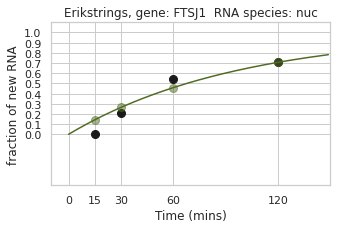

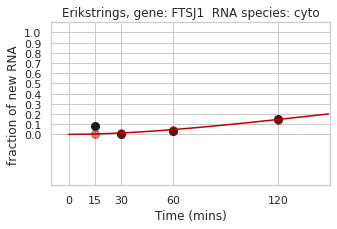

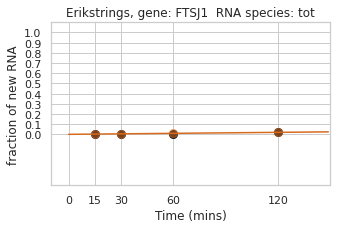

In [34]:
cmap={'chr':'#1D5386', 'nuc':'#506C23', 'cyto':'#B80000', 'poly':'#9E2E93', 'tot':'#D66B1F'}
  
for fr in fracs:
    sns.set(style="whitegrid", color_codes=True,font_scale=1)
    f, ax = plt.subplots(figsize=(5, 3))   
    ax.errorbar(x=time_measured, y=NTR[fr],
                fmt='o', ms=8,color='k') 
    ax.errorbar(x=time_measured, y=NTR_pred_measured[fr], 
                fmt='o', ms=8,color=cmap[fr],alpha=0.5)
    ax.errorbar(x=time_cont, y=NTR_pred_cont[fr], color=cmap[fr],alpha=1)

    plt.xticks(time_mins)
    plt.yticks([i*0.1 for i in range(11)])
    plt.xlim([-10,T_max])
    plt.ylim([-0.5,1.1])
    plt.xlabel('Time (mins)')
    plt.ylabel('fraction of new RNA')
    plt.title(assay_type + ', gene: '+gene+'  RNA species: '+fr)

### Fit timescales for all genes 
run for both assay_type = 'Erikstrings' and 'TimeLapse' 

In [39]:
logger.info('Run model parameter fitting for all Nanostrings genes')

filename = 'ES_MLE_'+assay_type+'.tsv'

#initialize the fit dictionary with columns
fits = dict()
fits['Symbol'] = []
for rt in RATE_TYPE:
    for ts in Timescales:
        fits[ts.replace('T_',rt)] = []         
for fr in fracs:
    fits[fr+'.chi2'] = []

#Fit all genes
count = 0
for gene in Nano_h:
    logger.info('%d %s' % (count, gene))
    logger.info('Write results to file %s' % filename)
    fits_df = pd.DataFrame(fits)
    fits_df.to_csv(os.path.join(path, filename), sep='\t',index=False)

    #initialize k_fit per gene
    k_fit = np.asarray([np.nan for t in Timescales])
    
    NTR = dict()
    for fr in fracs:
        #get NTR timeseries 
        NTR[fr] = ES[fr][ES[fr]['Symbol']==gene]
        NTR[fr] = NTR[fr][NTR[fr]['Time'].isin(time_measured)][assay_type].reset_index(drop=True)
        logger.info('%s NTR: %s' % (fr,NTR[fr].values))
    

        #get model fits
        model, init_para, bounds_para, fixed_para, fit_idx = get_model_fit_parts(fr)
        try:
            fit_val = least_squares(fit.calc_res, 
                                    init_para, 
                                    args=(model, time_measured, NTR[fr], fixed_para),
                                    bounds=bounds_para,
                                    gtol=1e-14, ftol=1e-14,
                                    loss='linear')
            k_fit[fit_idx] = fit_val.x[0]    
        except (IndexError, KeyError, ZeroDivisionError):
            logger.warning('%s: fail, so nan rates' % (fr))
                

    #append rates in fits dictionary  
    for rt in RATE_TYPE:
        for i, ts in enumerate(Timescales):
            if rt == 'half_life_':
                fits[ts.replace('T_',rt)].append(np.log(2)*(k_fit[i])**(-1))
            elif rt == 'k_':
                fits[ts.replace('T_',rt)].append(k_fit[i])
            elif rt == 'T_':
                fits[ts].append((k_fit[i])**(-1))
    
    #Get predictions
    NTR_model = dict()
    for fr in fracs:
        try:
            model, params = get_model_pred_para(fr, k_fit)
            NTR_model[fr] = model(params, time_measured)
            chi2 = get_chi2(NTR[fr], NTR_model[fr])
            fits[fr+'.chi2'].append(chi2)  
        except (IndexError, KeyError):
            fits[fr+'.chi2'].append(np.nan)
    
    fits['Symbol'].append(gene)
         
    count+=1

    

logger.info('Write results to file %s' % filename)
fits_df = pd.DataFrame(fits)
fits_df.to_csv(os.path.join(path, filename), sep='\t',index=False)
logger.info('end')

# if __name__ == '__main__':
#     main()

INFO: [2022-03-30 23:28:42] Erikstrings_MLE - Run model parameter fitting for all Nanostrings genes
INFO: [2022-03-30 23:28:42] Erikstrings_MLE - 0 FTSJ1
INFO: [2022-03-30 23:28:42] Erikstrings_MLE - Write results to file ES_MLE_TimeLapse.tsv
INFO: [2022-03-30 23:28:42] Erikstrings_MLE - nuc NTR: [0.06635  0.26645  0.555275 0.6756  ]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - cyto NTR: [0.0007  0.0007  0.01155 0.08985]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - tot NTR: [0.0266  0.06665 0.09775 0.1269 ]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - 1 RPS6KA3
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - Write results to file ES_MLE_TimeLapse.tsv
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - nuc NTR: [0.224725 0.36525  0.53     0.526625]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - cyto NTR: [0.00025 0.0085  0.0346  0.0663 ]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - tot NTR: [0.02265 0.084   0.1189  0.1017 ]
INFO: [2022-03-30 23:28:43] Erikstrings_MLE - 2 MYLK3
INFO: [2022-03

INFO: [2022-03-30 23:28:45] Erikstrings_MLE - nuc NTR: [0.11445  0.1828   0.310875 0.4812  ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - cyto NTR: [0.016925 0.049875 0.181625 0.38195 ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - tot NTR: [0.09055  0.101975 0.230475 0.47535 ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - 20 CDCA2
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - Write results to file ES_MLE_TimeLapse.tsv
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - nuc NTR: [0.06145  0.155925 0.27115  0.48645 ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - cyto NTR: [0.00585  0.0337   0.175375 0.3682  ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - tot NTR: [0.0328   0.113975 0.2713   0.496   ]
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - Write results to file ES_MLE_TimeLapse.tsv
INFO: [2022-03-30 23:28:45] Erikstrings_MLE - end
